In [124]:
import json
import os
import pickle
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np

In [116]:
def lowpass(y, x, lowcut, order):
    assert len(x) == len(y)
    fs = len(x)/(x[-1] - x[0])
    nyq = 0.5 * fs
    low = min(0.999, lowcut/nyq)
    b, a = signal.butter(order, low, btype="low")
    y_low = signal.filtfilt(b, a, y, axis=0)
    return y_low

def extract_self_play_score(result, player_id):
    return [el["evaluation"]["custom_metrics"][f"{player_id}_score_mean"] for el in result]

def extract_vs_random_score(result, player_id):
    return [el["custom_metrics"][f"{player_id}_score_mean"] for el in result]
    
def extract_time(result):
    return [el["time_total_s"] for el in result]

def load_result_json(ray_base_dir, game, experiment):
    file_path = os.path.join(ray_base_dir, game, experiment, "result.json")
    result = []
    with open(file_path, "rb") as file:
        for line in file:
            json_line = json.loads(line)
            result.append(json_line)
    return result

In [152]:
"""
Result keys:
['episode_reward_max', 'episode_reward_min', 'episode_reward_mean', 'episode_len_mean', 'episodes_this_iter',
'policy_reward_min', 'policy_reward_max', 'policy_reward_mean', 'custom_metrics', 'hist_stats', 'sampler_perf', 
'off_policy_estimator', 'num_healthy_workers', 'timesteps_total', 'timers', 'info', 'done', 'episodes_total', 
'training_iteration', 'experiment_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 
'node_ip', 'config', 'time_since_restore', 'timesteps_since_restore', 'iterations_since_restore', 'perf', 
'callback_ok', 'evaluation', 'trial_id', 'experiment_tag']

Evaluation keys:
['episode_reward_max', 'episode_reward_min', 'episode_reward_mean', 'episode_len_mean', 'episodes_this_iter',
'policy_reward_min', 'policy_reward_max', 'policy_reward_mean', 'custom_metrics', 'hist_stats', 'sampler_perf', 
'off_policy_estimator'])

Custom metrics keys:
['player_2_score_mean', 'player_2_score_min', 'player_2_score_max', 'player_1_score_mean', 'player_1_score_min',
'player_1_score_max']

"""

ray_base_dir = "../ray_results"

game_to_experiments_dict = {
    "blackjack": [
        "DQN_blackjack_0_2020-07-09_22-29-10o7dmnutp",
        "A2C_blackjack_0_2020-07-10_22-31-01l81e6kpw",
        "PPO_blackjack_0_2020-07-08_23-02-08g2o479xl"],
    "leduc-holdem": [
        "DQN_leduc-holdem_0_2020-07-10_22-10-036memcnqj",
        "A2C_leduc-holdem_0_2020-07-11_09-04-2339s424_3",
        "PPO_leduc-holdem_0_2020-07-09_05-40-19shdv1aw9",
        "DQN-vs-random_leduc-holdem_0_2020-07-11_16-30-348srrzvsd"
    ],
    "limit-holdem": [
        "DQN_limit-holdem_0_2020-07-11_00-22-28rhejzbd8",
        "A2C_limit-holdem_0_2020-07-11_10-20-24ewvwlolq",
        "PPO_limit-holdem_0_2020-07-09_07-14-091ofypgqk",
        "DQN-vs-random_limit-holdem_0_2020-07-11_17-33-563qv8j_bf"
    ],
    "no-limit-holdem": [
        "DQN_no-limit-holdem_0_2020-07-11_03-05-21d1oqv13_",
        "A2C_no-limit-holdem_0_2020-07-11_11-36-225s6apqg5",
        "PPO_no-limit-holdem_0_2020-07-09_19-59-501ozdjcr9",
        "DQN-vs-random_no-limit-holdem_0_2020-07-11_18-36-49gujpr13h"
    ],
    "uno": [
        "DQN_uno_0_2020-07-12_17-06-22sjeyg_mr",
        "A2C_uno_0_2020-07-11_15-00-18i_5iq61q",
        "PPO_uno_0_2020-07-09_21-27-36plcvy16d",
        "DQN-vs-random_uno_0_2020-07-12_11-03-117btkkces"
    ],
    "scopone": [
        "DQN_scopone_0_2020-07-12_13-25-58v8nj63qq",
        "A2C_scopone_0_2020-07-11_19-46-11opyirc0d",
        "PPO_scopone_2020-07-06_22-59-50_evaluation_1",
        "DQN-vs-random_scopone_0_2020-07-12_12-03-474ji9b08c"
    ]
}

results = {game: {} for game in game_to_experiments_dict}

for game, experiment_list in game_to_experiments_dict.items():
    for experiment in experiment_list:
        result = load_result_json(ray_base_dir, game, experiment)
        results[game].update({experiment.split("_")[0]: result})

DQN
A2C
PPO
DQN-vs-random


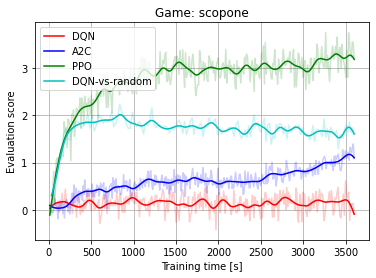

In [159]:
color_list = ["r", "b", "g", "c", "gr", "bk"]
for game, policy_to_results in results.items():
    for idx, (policy, result) in enumerate(policy_to_results.items()):
        print(policy)
        if "vs-random" in policy:
            policy_score = extract_vs_random_score(result, "player_1")
        else:            policy_score = extract_self_play_score(result, "player_1")
        time = extract_time(result)
        policy_score_plot = lowpass(policy_score, time, 0.005, 3)
        plt.plot(time, policy_score_plot, color_list[idx], label=policy)
        plt.plot(time, policy_score, color_list[idx], alpha=0.2)
    plt.legend()
    plt.grid()
    plt.title(f"Game: {game}")
    plt.xlabel("Training time [s]")
    plt.ylabel("Evaluation score")
    plt.show()

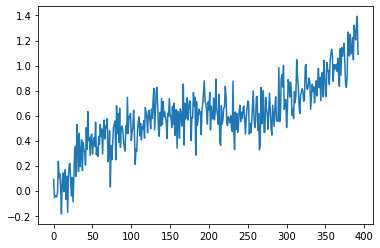

1.0510697674418603


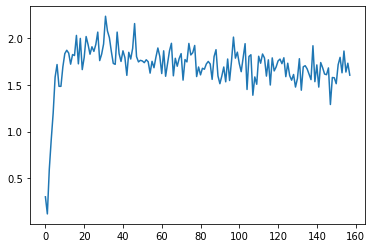

1.645090386609093


In [161]:
game = "scopone"

result = results[game]["A2C"]
scores = extract_self_play_score(result, "player_1")

plt.plot(scores)
plt.show()

print(np.mean(scores[350:]))

result = results[game]["DQN-vs-random"]
scores = extract_vs_random_score(result, "player_1")

plt.plot(scores)
plt.show()

print(np.mean(scores[120:]))

In [150]:
arena_game = "arena"
experiment_list = [
    "A2C_vs_DQN_random_leduc-holdem_2020-07-12_14-04-51sjdu0bqx",
    "A2C_vs_DQN_random_limit-holdem_2020-07-12_10-41-06mo6itp5f",
    "DQN_vs_DQN_random_no-limit-holdem_2020-07-12_14-58-54mz4sxz3s",
    "DQN_vs_DQN_random_uno_2020-07-12_19-11-21k43v41z3"
]
for experiment in experiment_list:
    arena_result = load_result_json(ray_base_dir, arena_game, experiment)
    self_play_score = np.mean(extract_vs_random_score(arena_result, "player_1"))
    random_train_score = np.mean(extract_vs_random_score(arena_result, "player_2"))

    print(f"===== Experiment: {experiment} =====")
    print(f"Score self play: {self_play_score}")
    print(f"Score random agent train: {random_train_score}")

===== Experiment: A2C_vs_DQN_random_leduc-holdem_2020-07-12_14-04-51sjdu0bqx =====
Score self play: -0.31907538741835684
Score random agent train: 0.31907538741835684
===== Experiment: A2C_vs_DQN_random_limit-holdem_2020-07-12_10-41-06mo6itp5f =====
Score self play: 0.12521104729306715
Score random agent train: -0.12521104729306715
===== Experiment: DQN_vs_DQN_random_no-limit-holdem_2020-07-12_14-58-54mz4sxz3s =====
Score self play: 0.06521972246375603
Score random agent train: -0.06521972246375603
===== Experiment: DQN_vs_DQN_random_uno_2020-07-12_19-11-21k43v41z3 =====
Score self play: -0.0001156176250403075
Score random agent train: 0.0001156176250403075


In [125]:
score = extract_vs_random_score(arena_result, "player_1")
print(np.mean(score))

-0.31907538741835684
